In [6]:
# Cell 1: Setup & Imports
import sys
import numpy as np
import matplotlib.pyplot as plt

# Import PurePursuitController
from path_trajectory_pkg.trajectory_controller import PurePursuitController

print("✓ Imports successful")
print("✓ PurePursuitController loaded\n")


✓ Imports successful
✓ PurePursuitController loaded



# Cell 2: Create Test Trajectory and Robot States

In [7]:

# Create a simple circular trajectory
n_points = 50
theta = np.linspace(0, 2*np.pi, n_points)
radius = 5.0

test_trajectory = {
    'x': radius * np.cos(theta),
    'y': radius * np.sin(theta),
    'time': np.linspace(0, 20, n_points),
    'velocity': np.ones(n_points) * 0.5  # Constant 0.5 m/s
}

# Create test robot poses at different positions
test_robot_poses = {
    'start': (radius, 0.0, np.pi/2),  # (x, y, theta)
    'on_path': (radius * np.cos(np.pi/4), radius * np.sin(np.pi/4), 3*np.pi/4),
    'inside_circle': (2.0, 2.0, np.pi),
    'outside_circle': (8.0, 0.0, np.pi),
    'near_goal': (radius * np.cos(1.9*np.pi), radius * np.sin(1.9*np.pi), 0.0)
}

print("✓ Test trajectory created")
print(f"  - Trajectory: {len(test_trajectory['x'])} points")
print(f"  - Path shape: Circular (radius={radius} m)")
print(f"  - Test robot poses: {len(test_robot_poses)} scenarios\n")


✓ Test trajectory created
  - Trajectory: 50 points
  - Path shape: Circular (radius=5.0 m)
  - Test robot poses: 5 scenarios



# Cell 3A: Test Core Navigation Functions

In [8]:
print("="*60)
print("TESTING CORE NAVIGATION FUNCTIONS")
print("="*60)

# Controller parameters
lookahead_distance = 0.5
k_lookahead = 0.1
min_lookahead = 0.3
max_lookahead = 1.0
goal_tolerance = 0.15

# Test 1: find_closest_point()
print("\n[Test 1] find_closest_point()")
print("-" * 60)

def find_closest_point(robot_pose, trajectory):
    """Find closest point on trajectory to robot."""
    x_robot, y_robot, _ = robot_pose
    dx = trajectory['x'] - x_robot
    dy = trajectory['y'] - y_robot
    distances = np.sqrt(dx**2 + dy**2)
    closest_idx = np.argmin(distances)
    return closest_idx, distances[closest_idx]

print("Purpose: Find nearest waypoint to robot's current position")
print("Results:")

for name, pose in test_robot_poses.items():
    idx, dist = find_closest_point(pose, test_trajectory)
    print(f"  • {name:15s}: idx={idx:2d}, distance={dist:.3f} m")

# Test specific case
test_pose = test_robot_poses['on_path']
idx, dist = find_closest_point(test_pose, test_trajectory)
if dist < 0.5:  # Should be very close if on path
    print(f"✅ PASS: On-path robot correctly identified (distance={dist:.3f} m)")
else:
    print(f"❌ FAIL: On-path robot has unexpected distance={dist:.3f} m")

# Test 2: compute_lookahead_point()
print("\n[Test 2] compute_lookahead_point()")
print("-" * 60)

def compute_lookahead_point(robot_pose, robot_velocity, trajectory, start_idx,
                            lookahead_distance, k_lookahead, min_lookahead, max_lookahead):
    """Compute adaptive lookahead point."""
    x_robot, y_robot, _ = robot_pose
    
    # Adaptive lookahead distance
    L = lookahead_distance + k_lookahead * robot_velocity
    L = np.clip(L, min_lookahead, max_lookahead)
    
    # Find first point at or beyond lookahead distance
    for i in range(start_idx, len(trajectory['x'])):
        dx = trajectory['x'][i] - x_robot
        dy = trajectory['y'][i] - y_robot
        distance = np.sqrt(dx**2 + dy**2)
        
        if distance >= L:
            return i, (trajectory['x'][i], trajectory['y'][i]), L
    
    # Use last point if nothing found
    last_idx = len(trajectory['x']) - 1
    return last_idx, (trajectory['x'][last_idx], trajectory['y'][last_idx]), L

print("Purpose: Find lookahead point ahead of robot")
print("Results:")

test_velocities = [0.0, 0.5, 1.0]
robot_pose = test_robot_poses['on_path']
closest_idx, _ = find_closest_point(robot_pose, test_trajectory)

for v in test_velocities:
    idx, point, L = compute_lookahead_point(
        robot_pose, v, test_trajectory, closest_idx,
        lookahead_distance, k_lookahead, min_lookahead, max_lookahead
    )
    print(f"  • v={v:.1f} m/s: L={L:.3f} m, lookahead_idx={idx}")

# Verify adaptive lookahead
L_slow = lookahead_distance + k_lookahead * 0.0
L_fast = lookahead_distance + k_lookahead * 1.0
if L_slow < L_fast:
    print(f"✅ PASS: Adaptive lookahead increases with velocity")
else:
    print(f"❌ FAIL: Adaptive lookahead not working correctly")

print("\n" + "="*60)
print("CORE NAVIGATION TESTS COMPLETE")
print("="*60 + "\n")


TESTING CORE NAVIGATION FUNCTIONS

[Test 1] find_closest_point()
------------------------------------------------------------
Purpose: Find nearest waypoint to robot's current position
Results:
  • start          : idx= 0, distance=0.000 m
  • on_path        : idx= 6, distance=0.080 m
  • inside_circle  : idx= 6, distance=2.172 m
  • outside_circle : idx= 0, distance=3.000 m
  • near_goal      : idx=47, distance=0.288 m
✅ PASS: On-path robot correctly identified (distance=0.080 m)

[Test 2] compute_lookahead_point()
------------------------------------------------------------
Purpose: Find lookahead point ahead of robot
Results:
  • v=0.0 m/s: L=0.500 m, lookahead_idx=7
  • v=0.5 m/s: L=0.550 m, lookahead_idx=7
  • v=1.0 m/s: L=0.600 m, lookahead_idx=8
✅ PASS: Adaptive lookahead increases with velocity

CORE NAVIGATION TESTS COMPLETE



# Cell 3B: Test Pure Pursuit Control Algorithm


In [9]:
print("="*60)
print("TESTING PURE PURSUIT CONTROL")
print("="*60)

# Test 3: pure_pursuit_control()
print("\n[Test 3] pure_pursuit_control()")
print("-" * 60)

def pure_pursuit_control(robot_pose, lookahead_point, trajectory, lookahead_idx):
    """Compute Pure Pursuit control commands."""
    x_robot, y_robot, theta_robot = robot_pose
    x_goal, y_goal = lookahead_point
    
    # Transform goal to robot frame
    dx = x_goal - x_robot
    dy = y_goal - y_robot
    
    dx_robot = np.cos(theta_robot) * dx + np.sin(theta_robot) * dy
    dy_robot = -np.sin(theta_robot) * dx + np.cos(theta_robot) * dy
    
    L = np.sqrt(dx_robot**2 + dy_robot**2)
    
    if L < 1e-3:
        return 0.0, 0.0
    
    # Pure Pursuit curvature: κ = 2*y_robot/L²
    curvature = 2.0 * dy_robot / (L ** 2)
    
    # Get desired velocity from trajectory
    v_desired = trajectory['velocity'][lookahead_idx]
    
    # Limit angular velocity
    max_omega = 1.0
    if abs(curvature * v_desired) > max_omega:
        v_desired = max_omega / abs(curvature) if abs(curvature) > 1e-6 else v_desired
    
    omega = v_desired * curvature
    
    return v_desired, omega

print("Purpose: Compute velocity commands using Pure Pursuit law")
print("Formula: κ = 2*y_robot/L², ω = v*κ")
print("\nResults:")

# Test different scenarios
test_scenarios = [
    ("on_path", test_robot_poses['on_path']),
    ("inside_circle", test_robot_poses['inside_circle']),
    ("outside_circle", test_robot_poses['outside_circle'])
]

for name, pose in test_scenarios:
    closest_idx, _ = find_closest_point(pose, test_trajectory)
    lookahead_idx, lookahead_point, L = compute_lookahead_point(
        pose, 0.5, test_trajectory, closest_idx,
        lookahead_distance, k_lookahead, min_lookahead, max_lookahead
    )
    v, omega = pure_pursuit_control(pose, lookahead_point, test_trajectory, lookahead_idx)
    
    print(f"  • {name:15s}: v={v:.3f} m/s, ω={omega:.3f} rad/s")

# Verify straight path gives low omega
straight_pose = (0.0, 0.0, 0.0)  # Robot heading toward lookahead
straight_lookahead = (1.0, 0.0)
v, omega = pure_pursuit_control(straight_pose, straight_lookahead, test_trajectory, 0)

if abs(omega) < 0.1:
    print(f"✅ PASS: Straight path produces low angular velocity (ω={omega:.3f})")
else:
    print(f"❌ FAIL: Straight path produces high angular velocity (ω={omega:.3f})")

# Test 4: normalize_angle()
print("\n[Test 4] normalize_angle()")
print("-" * 60)

def normalize_angle(angle):
    """Normalize angle to [-π, π]."""
    while angle > np.pi:
        angle -= 2.0 * np.pi
    while angle < -np.pi:
        angle += 2.0 * np.pi
    return angle

print("Purpose: Normalize angles to [-π, π] range")
print("Results:")

test_angles = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, -np.pi, -3*np.pi/2]
for angle in test_angles:
    normalized = normalize_angle(angle)
    print(f"  • {angle:6.3f} → {normalized:6.3f} rad ({np.degrees(normalized):6.1f}°)")

# Verify range
all_normalized = [normalize_angle(a) for a in test_angles]
if all(-np.pi <= a <= np.pi for a in all_normalized):
    print(f"✅ PASS: All angles normalized to [-π, π]")
else:
    print(f"❌ FAIL: Some angles outside range")

print("\n" + "="*60)
print("PURE PURSUIT CONTROL TESTS COMPLETE")
print("="*60 + "\n")


TESTING PURE PURSUIT CONTROL

[Test 3] pure_pursuit_control()
------------------------------------------------------------
Purpose: Compute velocity commands using Pure Pursuit law
Formula: κ = 2*y_robot/L², ω = v*κ

Results:
  • on_path        : v=0.500 m/s, ω=0.100 rad/s
  • inside_circle  : v=0.500 m/s, ω=-0.313 rad/s
  • outside_circle : v=0.500 m/s, ω=0.000 rad/s
✅ PASS: Straight path produces low angular velocity (ω=0.000)

[Test 4] normalize_angle()
------------------------------------------------------------
Purpose: Normalize angles to [-π, π] range
Results:
  •  0.000 →  0.000 rad (   0.0°)
  •  1.571 →  1.571 rad (  90.0°)
  •  3.142 →  3.142 rad ( 180.0°)
  •  4.712 → -1.571 rad ( -90.0°)
  •  6.283 →  0.000 rad (   0.0°)
  • -3.142 → -3.142 rad (-180.0°)
  • -4.712 →  1.571 rad (  90.0°)
✅ PASS: All angles normalized to [-π, π]

PURE PURSUIT CONTROL TESTS COMPLETE



# Cell 3C: Test Goal Detection and Error Tracking

In [10]:
print("="*60)
print("TESTING GOAL DETECTION & ERROR TRACKING")
print("="*60)

# Test 5: is_goal_reached()
print("\n[Test 5] is_goal_reached()")
print("-" * 60)

def is_goal_reached(robot_pose, trajectory, current_idx, goal_tolerance):
    """Check if robot reached goal."""
    # Must progress through 90% of trajectory
    trajectory_length = len(trajectory['x'])
    progress_threshold = int(0.9 * trajectory_length)
    
    if current_idx < progress_threshold:
        return False, 0.0
    
    # Check distance to goal
    x_robot, y_robot, _ = robot_pose
    x_goal = trajectory['x'][-1]
    y_goal = trajectory['y'][-1]
    
    distance = np.sqrt((x_goal - x_robot)**2 + (y_goal - y_robot)**2)
    
    return distance < goal_tolerance, distance

print(f"Purpose: Detect when robot reaches goal")
print(f"Criteria: (1) Progress >90%, (2) Distance < {goal_tolerance} m")
print("\nResults:")

# Test near start
pose_start = test_robot_poses['start']
idx_start, _ = find_closest_point(pose_start, test_trajectory)
reached, dist = is_goal_reached(pose_start, test_trajectory, idx_start, goal_tolerance)
print(f"  • Near start (idx={idx_start}):  reached={reached}, dist={dist:.3f} m")

# Test near goal
pose_goal = test_robot_poses['near_goal']
idx_goal, _ = find_closest_point(pose_goal, test_trajectory)
reached, dist = is_goal_reached(pose_goal, test_trajectory, idx_goal, goal_tolerance)
print(f"  • Near goal (idx={idx_goal}):   reached={reached}, dist={dist:.3f} m")

# Verify logic
if not reached and idx_start < 5:
    print(f"✅ PASS: Start position correctly not marked as goal")
else:
    print(f"❌ FAIL: Goal detection logic incorrect")

# Test 6: track_errors()
print("\n[Test 6] track_errors()")
print("-" * 60)

def track_errors(robot_pose, robot_velocity, trajectory, closest_idx, lookahead_idx):
    """Track performance errors."""
    x_robot, y_robot, theta_robot = robot_pose
    
    # Cross-track error
    x_closest = trajectory['x'][closest_idx]
    y_closest = trajectory['y'][closest_idx]
    cross_track_error = np.sqrt(
        (x_closest - x_robot)**2 + (y_closest - y_robot)**2
    )
    
    # Heading error
    dx = trajectory['x'][lookahead_idx] - x_robot
    dy = trajectory['y'][lookahead_idx] - y_robot
    desired_heading = np.arctan2(dy, dx)
    heading_error = normalize_angle(desired_heading - theta_robot)
    
    # Velocity error
    v_desired = trajectory['velocity'][closest_idx]
    velocity_error = abs(v_desired - robot_velocity)
    
    return {
        'cross_track': cross_track_error,
        'heading': abs(heading_error),
        'velocity': velocity_error
    }

print("Purpose: Compute tracking performance metrics")
print("Results:")

for name, pose in [("on_path", test_robot_poses['on_path']),
                   ("inside_circle", test_robot_poses['inside_circle'])]:
    closest_idx, _ = find_closest_point(pose, test_trajectory)
    lookahead_idx, _, _ = compute_lookahead_point(
        pose, 0.5, test_trajectory, closest_idx,
        lookahead_distance, k_lookahead, min_lookahead, max_lookahead
    )
    errors = track_errors(pose, 0.5, test_trajectory, closest_idx, lookahead_idx)
    
    print(f"  • {name:15s}:")
    print(f"      Cross-track: {errors['cross_track']:.3f} m")
    print(f"      Heading:     {np.degrees(errors['heading']):.1f}°")
    print(f"      Velocity:    {errors['velocity']:.3f} m/s")

# Verify on-path has low cross-track error
pose = test_robot_poses['on_path']
closest_idx, _ = find_closest_point(pose, test_trajectory)
lookahead_idx, _, _ = compute_lookahead_point(
    pose, 0.5, test_trajectory, closest_idx,
    lookahead_distance, k_lookahead, min_lookahead, max_lookahead
)
errors = track_errors(pose, 0.5, test_trajectory, closest_idx, lookahead_idx)

if errors['cross_track'] < 0.5:
    print(f"✅ PASS: On-path tracking has low error ({errors['cross_track']:.3f} m)")
else:
    print(f"❌ FAIL: On-path tracking has high error ({errors['cross_track']:.3f} m)")

print("\n" + "="*60)
print("GOAL & ERROR TRACKING TESTS COMPLETE")
print("="*60 + "\n")


TESTING GOAL DETECTION & ERROR TRACKING

[Test 5] is_goal_reached()
------------------------------------------------------------
Purpose: Detect when robot reaches goal
Criteria: (1) Progress >90%, (2) Distance < 0.15 m

Results:
  • Near start (idx=0):  reached=False, dist=0.000 m
  • Near goal (idx=47):   reached=False, dist=1.564 m
✅ PASS: Start position correctly not marked as goal

[Test 6] track_errors()
------------------------------------------------------------
Purpose: Compute tracking performance metrics
Results:
  • on_path        :
      Cross-track: 0.080 m
      Heading:     3.2°
      Velocity:    0.000 m/s
  • inside_circle  :
      Cross-track: 2.172 m
      Heading:     137.1°
      Velocity:    0.000 m/s
✅ PASS: On-path tracking has low error (0.080 m)

GOAL & ERROR TRACKING TESTS COMPLETE



# Cell 4: Pure Pursuit Visualization

✓ Visualization complete
✓ Saved as: pure_pursuit_controller_test_results.png



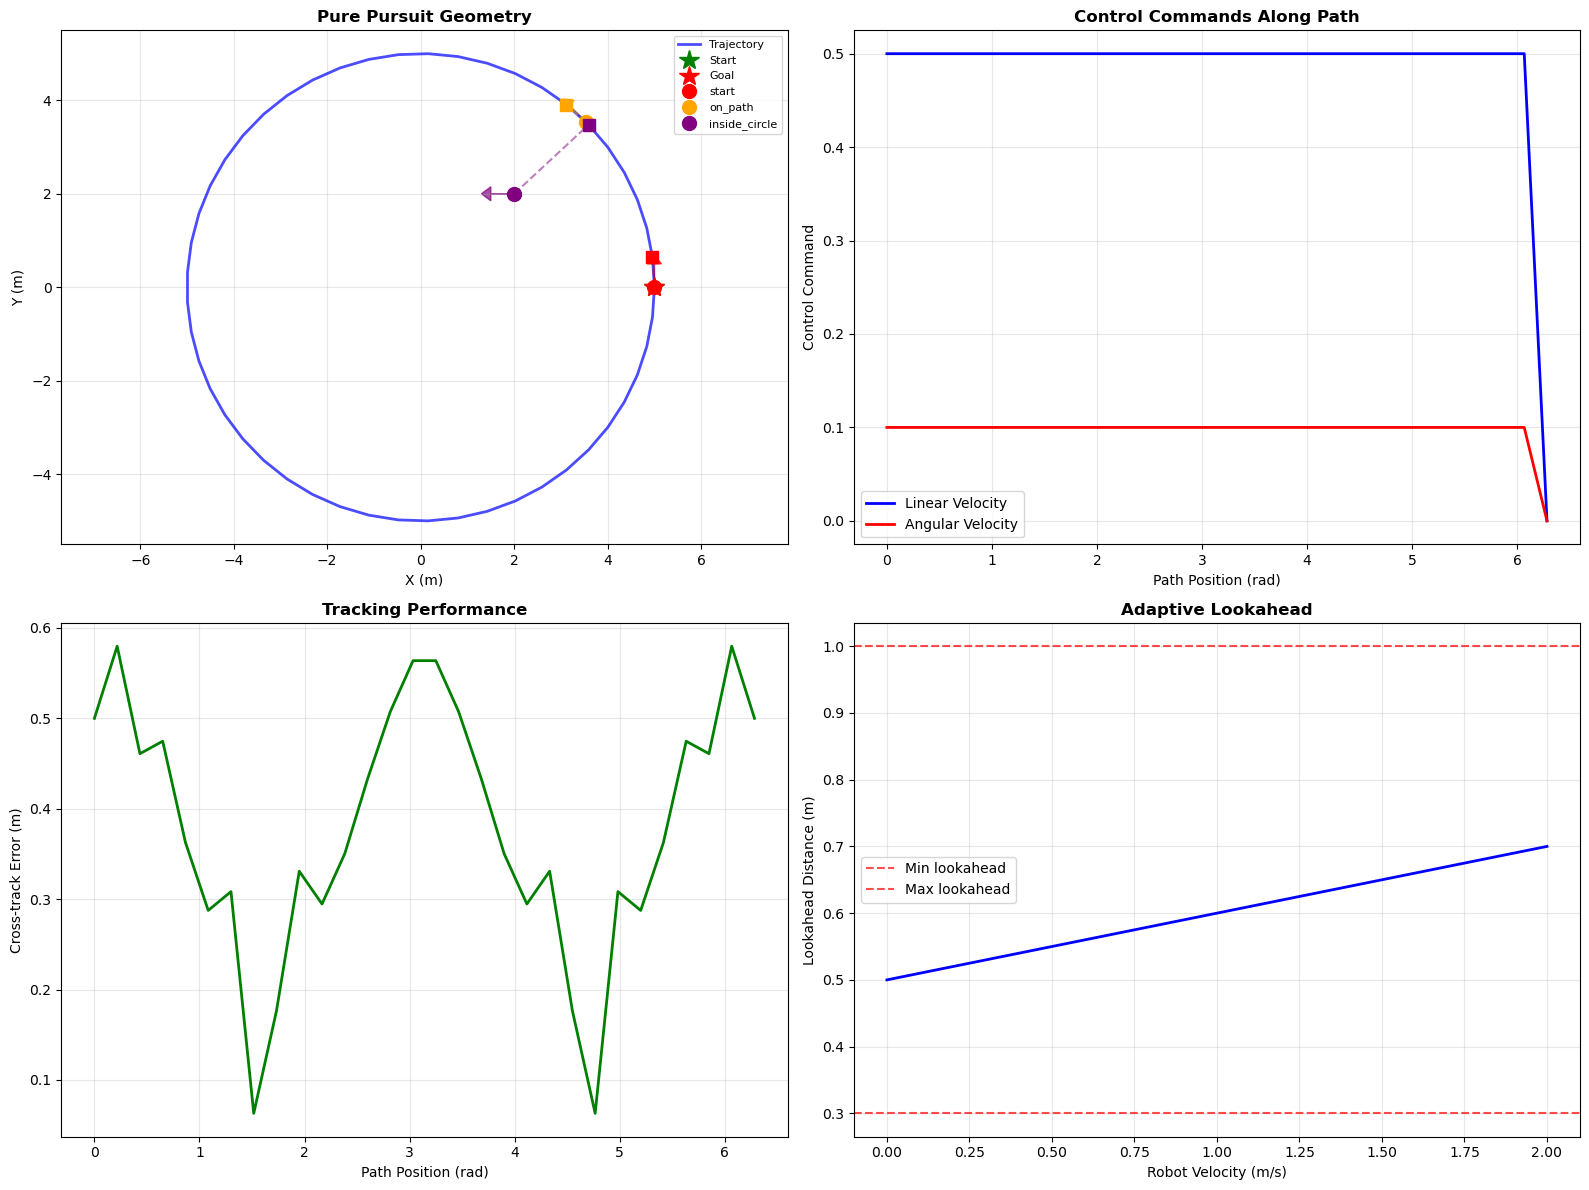

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Pure Pursuit Geometry
ax = axes[0, 0]

# Plot trajectory
ax.plot(test_trajectory['x'], test_trajectory['y'], 'b-', 
        linewidth=2, label='Trajectory', alpha=0.7)
ax.plot(test_trajectory['x'][0], test_trajectory['y'][0], 'g*', 
        markersize=15, label='Start')
ax.plot(test_trajectory['x'][-1], test_trajectory['y'][-1], 'r*', 
        markersize=15, label='Goal')

# Plot robot positions and lookahead points
colors = ['red', 'orange', 'purple']
for idx, (name, pose) in enumerate(list(test_robot_poses.items())[:3]):
    x, y, theta = pose
    
    # Robot position
    ax.plot(x, y, 'o', color=colors[idx], markersize=10, label=f'{name}')
    
    # Robot heading
    dx_heading = 0.5 * np.cos(theta)
    dy_heading = 0.5 * np.sin(theta)
    ax.arrow(x, y, dx_heading, dy_heading, head_width=0.3, 
             head_length=0.2, fc=colors[idx], ec=colors[idx], alpha=0.7)
    
    # Lookahead point
    closest_idx, _ = find_closest_point(pose, test_trajectory)
    lookahead_idx, lookahead_point, L = compute_lookahead_point(
        pose, 0.5, test_trajectory, closest_idx,
        lookahead_distance, k_lookahead, min_lookahead, max_lookahead
    )
    
    ax.plot([x, lookahead_point[0]], [y, lookahead_point[1]], 
            '--', color=colors[idx], alpha=0.5)
    ax.plot(lookahead_point[0], lookahead_point[1], 's', 
            color=colors[idx], markersize=8)

ax.set_xlabel('X (m)', fontsize=10)
ax.set_ylabel('Y (m)', fontsize=10)
ax.set_title('Pure Pursuit Geometry', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Control Commands
ax = axes[0, 1]

positions = np.linspace(0, 2*np.pi, 30)
velocities = []
omegas = []

for pos in positions:
    pose = (radius * np.cos(pos), radius * np.sin(pos), pos + np.pi/2)
    closest_idx, _ = find_closest_point(pose, test_trajectory)
    lookahead_idx, lookahead_point, _ = compute_lookahead_point(
        pose, 0.5, test_trajectory, closest_idx,
        lookahead_distance, k_lookahead, min_lookahead, max_lookahead
    )
    v, omega = pure_pursuit_control(pose, lookahead_point, test_trajectory, lookahead_idx)
    velocities.append(v)
    omegas.append(omega)

ax.plot(positions, velocities, 'b-', linewidth=2, label='Linear Velocity')
ax.plot(positions, omegas, 'r-', linewidth=2, label='Angular Velocity')
ax.set_xlabel('Path Position (rad)', fontsize=10)
ax.set_ylabel('Control Command', fontsize=10)
ax.set_title('Control Commands Along Path', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Cross-track Error
ax = axes[1, 0]

cross_track_errors = []
for pos in positions:
    pose = (radius * np.cos(pos) + 0.5, radius * np.sin(pos), pos + np.pi/2)  # Offset
    closest_idx, _ = find_closest_point(pose, test_trajectory)
    lookahead_idx, _, _ = compute_lookahead_point(
        pose, 0.5, test_trajectory, closest_idx,
        lookahead_distance, k_lookahead, min_lookahead, max_lookahead
    )
    errors = track_errors(pose, 0.5, test_trajectory, closest_idx, lookahead_idx)
    cross_track_errors.append(errors['cross_track'])

ax.plot(positions, cross_track_errors, 'g-', linewidth=2)
ax.set_xlabel('Path Position (rad)', fontsize=10)
ax.set_ylabel('Cross-track Error (m)', fontsize=10)
ax.set_title('Tracking Performance', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Lookahead Distance Adaptation
ax = axes[1, 1]

velocities_test = np.linspace(0, 2.0, 20)
lookahead_distances = []

for v in velocities_test:
    L = lookahead_distance + k_lookahead * v
    L = np.clip(L, min_lookahead, max_lookahead)
    lookahead_distances.append(L)

ax.plot(velocities_test, lookahead_distances, 'b-', linewidth=2)
ax.axhline(y=min_lookahead, color='r', linestyle='--', label='Min lookahead', alpha=0.7)
ax.axhline(y=max_lookahead, color='r', linestyle='--', label='Max lookahead', alpha=0.7)
ax.set_xlabel('Robot Velocity (m/s)', fontsize=10)
ax.set_ylabel('Lookahead Distance (m)', fontsize=10)
ax.set_title('Adaptive Lookahead', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pure_pursuit_controller_test_results.png', dpi=150, bbox_inches='tight')
print("✓ Visualization complete")
print("✓ Saved as: pure_pursuit_controller_test_results.png\n")
plt.show()
